In [135]:
import Trial_Processing as pts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import config
import tdt

## Manual Loading Data
If you have the paths to the data but the names arent aligned or if you dont want to run the autoalignment script you can manually load the data 

In [136]:
trials_405A, trials_405C, trials_465A, trials_465C = pts.load_photometry_streams(
    config.remote_photometry_path + '/Social_Interaction-231005/M3_F1_M4_F2', 
    sample_rate=45, 
    trial_duration=30, 
    skip_trials=1,
    threshold=10,
    )

read from t=0s to t=35750.1s
Number of trials: 697


In [137]:
df = pts.write_photometry_to_csv(
    '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/October Test Data/csv files/20231005093139_log.csv', 
    '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/October Test Data/videos/20231005093138_SI.h264', 
    config.remote_photometry_path + '/Social_Interaction-231005/M3_F1_M4_F2', 
    None, 
    'M5', 
    'M6', 
    trial_duration=30, 
    skip_trials=1, 
    sample_rate=45, 
    cue_offset_seconds=0
)

read from t=0s to t=35750.1s
Number of trials: 697


In [138]:
photo_data = pts.PhotometryVideoData(df=df, trim_start=40)

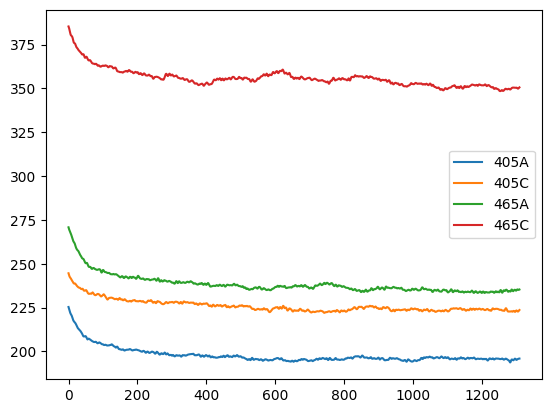

In [139]:
## You can use get_photometry_data to get the photometry data for a specific trial
## The first argument is the trial number (0-indexed)
## Returns a dict keyed by the 4 different channels (405A, 405C, 465A, 465C)
plt.plot(photo_data.get_photometry_data(0)['405A'], label='405A')
plt.plot(photo_data.get_photometry_data(0)['405C'], label='405C')
plt.plot(photo_data.get_photometry_data(0)['465A'], label='465A')
plt.plot(photo_data.get_photometry_data(0)['465C'], label='465C')
plt.legend()
plt.show()

In [140]:
## You Can Use get_trial_data to get all the experimental data for a given trial
display(photo_data.get_trial_data(1))

cue_time in s                    20231005093235596856
trig_fib_photometry_time in s    20231005093230587814
M5_L_rewards                                        0
M5_L_beambreak_time in s                          NaN
M5_L_reward time in s                             NaN
M6_R_rewards                                        0
M6_R_beambreak_time in s                          NaN
M6_R_reward time in s                             NaN
M5_L_beambreak_time                 1696523571.619023
M5_L_reward time                                  NaN
M6_R_beambreak_time                 1696523571.621194
M6_R_reward time                                  NaN
cue_time                            1696523555.596856
trig_fib_photometry_time            1696523550.587814
Name: 1, dtype: object

In [157]:
successful_trials = []
failed_trials = []
for i in range(690):
    photometry = photo_data.get_photometry_data(i)
    trial = photo_data.get_trial_data(i)
    ## We have to find the names of the indexes for the break times manually
    break_time_one = float(trial['M5_L_beambreak_time in s'])
    break_time_two = float(trial['M6_R_beambreak_time in s'])
    ## If both break times are NaN, then the trial was not successful
    trial_successful = (~(np.isnan(float(break_time_one)) and np.isnan(float(break_time_two))))
    trial_successful = True
    if trial_successful:
        successful_trials.append(photometry)
    else:
        failed_trials.append(photometry)

In [158]:
def dff_zscore(trace, baseline):
    mean_trace = np.mean(trace)
    mean_baseline = np.mean(baseline)
    corrected_signal = trace / mean_trace - baseline / mean_baseline
    return (corrected_signal - np.mean(corrected_signal, axis=0)) / np.std(corrected_signal)

(array([  7.,  18.,  49., 103., 165., 168.,  92.,  62.,  18.,   8.]),
 array([-0.7401098 , -0.58589135, -0.43167291, -0.27745446, -0.12323602,
         0.03098243,  0.18520087,  0.33941932,  0.49363776,  0.64785621,
         0.80207466]),
 <BarContainer object of 10 artists>)

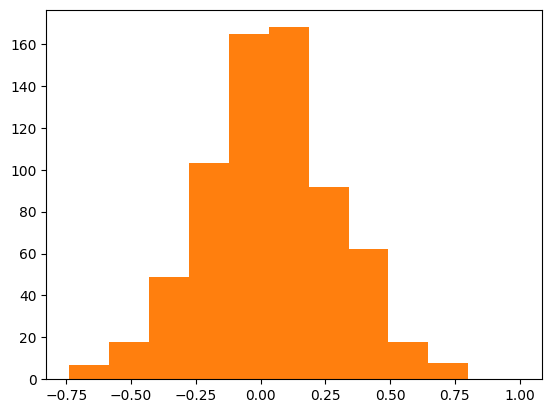

In [159]:
from scipy.stats import pearsonr
## plot all the successful trials
correlations_success = []
correlations_fail = []
sucessful_zscores_A = []
sucessful_zscores_C = []
for trial in successful_trials:
    z_score_A = (dff_zscore(trial['465A'], trial['405A']))
    z_score_C = (dff_zscore(trial['465C'], trial['405C']))
    sucessful_zscores_A.extend(z_score_A)
    sucessful_zscores_C.extend(z_score_C)
    correlation = pearsonr(z_score_A, z_score_C)[0]
    correlations_success.append(correlation)
for trial in failed_trials:
    z_score_A = (dff_zscore(trial['465A'], trial['405A']))
    z_score_C = (dff_zscore(trial['465C'], trial['405C']))
    correlation = pearsonr(z_score_A, z_score_C)[0]
    correlations_fail.append(correlation)
## Plot a histogram of the correlations
plt.hist(correlations_fail, alpha=0.5)
plt.hist(correlations_success, alpha=1)

Text(0.5, 1.0, 'Correlation: 0.22034217367454562 Correlation Fail: 0.19512157582712925')

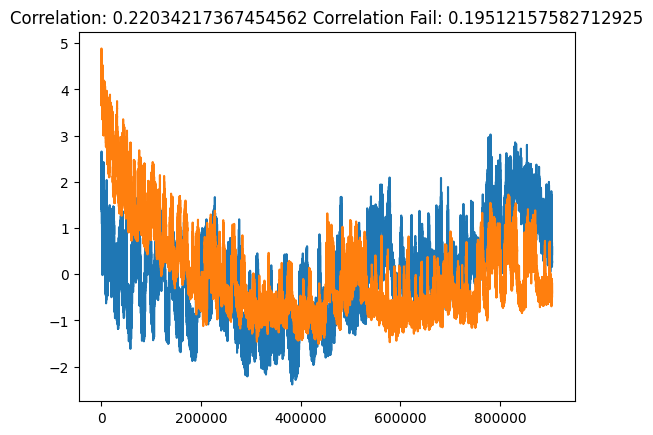

In [160]:
## concat together all the successful trial dicsts
for i in range(len(successful_trials)):
    if i == 0:
        concat_success = None
        concat_success = successful_trials[0].copy()
    else:
        concat_success['405A'] = np.concatenate((concat_success['405A'], successful_trials[i]['405A']))
        concat_success['405C'] = np.concatenate((concat_success['405C'], successful_trials[i]['405C']))
        concat_success['465A'] = np.concatenate((concat_success['465A'], successful_trials[i]['465A']))
        concat_success['465C'] = np.concatenate((concat_success['465C'], successful_trials[i]['465C']))

## concat together all the failed trial dicts
for i in range(len(failed_trials)):
    if i == 0:
        concat_fail = failed_trials[0]
    else:
        concat_fail['405A'] = np.concatenate((concat_fail['405A'], failed_trials[i]['405A']))
        concat_fail['405C'] = np.concatenate((concat_fail['405C'], failed_trials[i]['405C']))
        concat_fail['465A'] = np.concatenate((concat_fail['465A'], failed_trials[i]['465A']))
        concat_fail['465C'] = np.concatenate((concat_fail['465C'], failed_trials[i]['465C']))

## compute z-score of concated series
z_score_A_success = (dff_zscore(concat_success['465A'], concat_success['405A']))
z_score_C_success = (dff_zscore(concat_success['465C'], concat_success['405C']))
z_score_A_fail = (dff_zscore(concat_fail['465A'], concat_fail['405A']))
z_score_C_fail = (dff_zscore(concat_fail['465C'], concat_fail['405C']))

# compute correlation
correlation = pearsonr(z_score_A_success, z_score_C_success)[0]
correlation_fail = pearsonr(z_score_A_fail, z_score_C_fail)[0]
plt.plot(z_score_A_success, label='465A')
plt.plot(z_score_C_success, label='465C')
plt.title('Correlation: ' + str(correlation) + ' Correlation Fail: ' + str(correlation_fail))

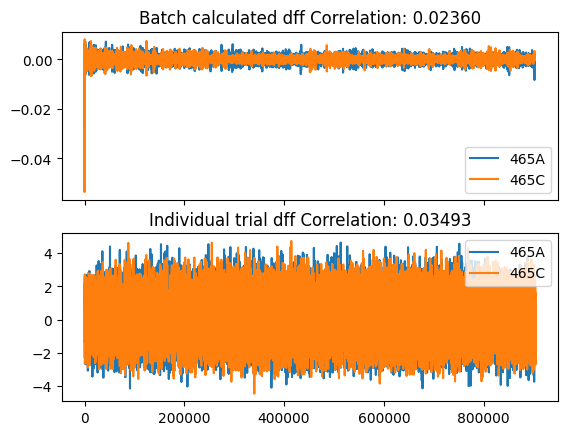

In [172]:
## Create 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# plot
# take moving average of z-scored data
window_size = 400
z_score_A_success =  (z_score_A_success- np.convolve(z_score_A_success, np.ones(window_size)/window_size, mode='same'))[window_size:-window_size]
z_score_C_success = (z_score_C_success - np.convolve(z_score_C_success, np.ones(window_size)/window_size, mode='same'))[window_size:-window_size]
ax1.plot(z_score_A_success, label='465A')
ax1.plot(z_score_C_success, label='465C')
corr = pearsonr(z_score_A_success, z_score_C_success)[0]
ax1.legend()
ax1.set_title('Batch calculated dff' + ' Correlation: ' + str(corr)[:7])
ax2.plot(sucessful_zscores_A, label='465A')
ax2.plot(sucessful_zscores_C, label='465C')
corr = pearsonr(sucessful_zscores_A, sucessful_zscores_C)[0]
ax2.set_title('Individual trial dff' + ' Correlation: ' + str(corr)[:7])
ax2.legend()

## PhotometryVideoData Object
This is the main object used for handling the photometry data, it can load data using ```get_photometry_data(trial)``` which lets you get 1 trial period of data, in addition you can also use ```get_all_photometry_data``` to get all the data in an array, as it returns a dict you can get each individual channel through keying with the channel name (405A, 405C, 465A, 465C)